# Sentiment Analysis using deep learning
<p>

In [82]:
#import statements
import pandas as pd
import numpy as np
import keras
import nltk
from nltk.tokenize import word_tokenize
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing required functions from keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras import layers
import keras.backend as K

#importing libraries required for preprocessing
import re
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', -1)
from sklearn.model_selection import train_test_split

# importing the required util function
import functions.utils
from functions.utils import *
from functions.utils import clean_text
from functions.utils import load_embedding, create_embedding_weights, max_seq_len
from keras.utils import to_categorical, plot_model

import functions.model_evaluation
from functions.model_evaluation import *

import functions.data_manipulation
from functions.data_manipulation import *

In [83]:
# loading datasets
train = pd.read_csv('data/train.txt', delimiter = '\t')
test = pd.read_csv('data/test.txt', delimiter = '\t')
trial = pd.read_csv('data/trial.txt', delimiter = '\t')
test_ann = pd.read_csv('data/test_anno.txt', delimiter = '\t')

In [84]:
#Cleaning the data
train['sentence_A'] = train['sentence_A'].apply(clean_text)
train['sentence_B'] = train['sentence_B'].apply(clean_text)
test['sentence_A'] = test['sentence_A'].apply(clean_text)
test['sentence_B'] = test['sentence_B'].apply(clean_text)
trial['sentence_A'] = trial['sentence_A'].apply(clean_text)
trial['sentence_B'] = trial['sentence_B'].apply(clean_text)

#encoding the target feature
lbl_enc = LabelEncoder()
train['entailment_encoded'] = lbl_enc.fit_transform(train['entailment_judgment'])
trial['entailment_encoded'] = lbl_enc.fit_transform(trial['entailment_judgment'])
############################For now############################################
test_ann['entailment_encoded'] = lbl_enc.fit_transform(test_ann['entailment_judgment'])

#loading the embedding
file_name = 'word_embeddings/glove.6B.300d.txt'
embeddings = load_embedding(file_name)


#tokenizing 
NUM_WORDS = len(embeddings) #200000
sentences = (list(train['sentence_A']) + list(train['sentence_B']) + 
                       list(test['sentence_A']) + list(test['sentence_B'])+ 
                           list(trial['sentence_A']) + list(trial['sentence_B']))
tokenize = Tokenizer(num_words = NUM_WORDS)
tokenize.fit_on_texts(sentences)
sent1_word_seq = tokenize.texts_to_sequences(train['sentence_A'])
sent2_word_seq = tokenize.texts_to_sequences(train['sentence_B'])
sent1_word_seq_test = tokenize.texts_to_sequences(test['sentence_A'])
sent2_word_seq_test = tokenize.texts_to_sequences(test['sentence_B'])
sent1_word_seq_trial = tokenize.texts_to_sequences(trial['sentence_A'])
sent2_word_seq_trial = tokenize.texts_to_sequences(trial['sentence_B'])
word_index = tokenize.word_index

#Matrix with the embedding weights
embedding_dim = 300
embedding_weights = create_embedding_weights(embeddings, embedding_dim, word_index, NUM_WORDS)

# extracting the maximum sequence length
max_seq_length = max_seq_len(sent1_word_seq)
max_seq_length = max_seq_len(sent2_word_seq, max_seq_length)
max_seq_length = max_seq_len(sent1_word_seq_test, max_seq_length)
max_seq_length = max_seq_len(sent2_word_seq_test, max_seq_length)
max_seq_length = max_seq_len(sent1_word_seq_trial, max_seq_length)
max_seq_length = max_seq_len(sent2_word_seq_trial, max_seq_length)

# padding the sequences
sent1_data = pad_sequences(sent1_word_seq, maxlen = max_seq_length)
sent2_data = pad_sequences(sent2_word_seq, maxlen = max_seq_length)

sent1_data_trial = pad_sequences(sent1_word_seq_trial, maxlen = max_seq_length)
sent2_data_trial = pad_sequences(sent2_word_seq_trial, maxlen = max_seq_length)

sent1_data_test = pad_sequences(sent1_word_seq_test, maxlen = max_seq_length)
sent2_data_test = pad_sequences(sent2_word_seq_test, maxlen = max_seq_length)
NUM_WORDS = len(embedding_weights)

labels = to_categorical(np.asarray(train['entailment_encoded']))
labels_valid = to_categorical(np.asarray(trial['entailment_encoded']))


### Running the model

# number of iterations, batch_size and validation split for the model
batch_size = 10
epochs = 10
#laoding the module from deep learning models
import models.models as models

m1 = models.models(embedding_dim,
                   NUM_WORDS, 
                   embedding_weights,
#                   dropout = .1,
#                   l2_reg = .0001
                   max_seq_length,
                  )

model = m1.siames()

#training the model
hist = model.fit([sent1_data, sent2_data], labels, batch_size = batch_size, 
                 epochs = epochs,
                 validation_data= ([sent1_data_trial, sent2_data_trial],labels_valid ))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 300)      692100      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 300)          721200      embedding_3[0][0]          

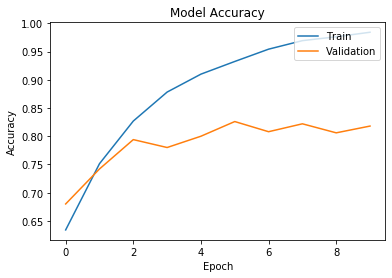

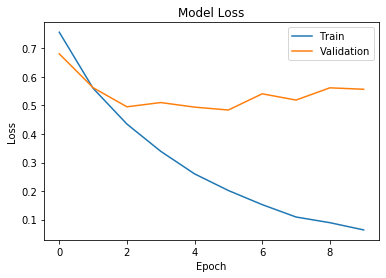

In [85]:
plot_model_training(hist)

In [90]:
k = model.predict([sent1_data_test, sent2_data_test])
result = convert_prob(k)
prec, rec, f1_s, acc = evaluate_model(test_ann['entailment_encoded'], result)

In [91]:
print("Precision: "+ str(prec))
print("Recall: "+ str(rec))
print("F1 Score: "+ str(f1_s))
print("Accuracy: "+ str(acc))

Precision: 0.8254765785194339
Recall: 0.8246397402070226
F1 Score: 0.8249535340561734
Accuracy: 0.8246397402070226


In [88]:
df = map_entailment(lbl_enc, result, test)

C:\Users\hkpat\Masters\NLP\Assignment2_final\submission\functions\data_manipulation.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['entailment_judgment'] =  entailment_result


## Part B)

In [7]:
# loading the model
m1 = models.models(embedding_dim = embedding_dim,
                   NUM_WORDS = NUM_WORDS,
                   embedding_weights = embedding_weights,
                   max_seq_length = max_seq_length,
                   task = 'relatedness',
                   dropout = .1,
                   l2_reg=.0001
                  )
model = m1.siames()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 300)      692100      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 300)          721200      embedding_2[0][0]          

In [8]:
hist = model.fit([sent1_data, sent2_data], train['relatedness_score'], batch_size = 10, 
                 epochs = 10,
                 validation_data = ([sent1_data_trial, sent2_data_trial], trial['relatedness_score']))

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 60s 13ms/step - loss: 0.9722 - pearson_correlation: 0.4094 - val_loss: 0.7397 - val_pearson_correlation: 0.6312
Epoch 2/10
4500/4500 [==============================] - 60s 13ms/step - loss: 0.5909 - pearson_correlation: 0.6545 - val_loss: 0.4766 - val_pearson_correlation: 0.6771
Epoch 3/10
4500/4500 [==============================] - 60s 13ms/step - loss: 0.4645 - pearson_correlation: 0.7400 - val_loss: 0.4331 - val_pearson_correlation: 0.7388
Epoch 4/10
4500/4500 [==============================] - 60s 13ms/step - loss: 0.3746 - pearson_correlation: 0.7934 - val_loss: 0.4035 - val_pearson_correlation: 0.7532
Epoch 5/10
4500/4500 [==============================] - 60s 13ms/step - loss: 0.3241 - pearson_correlation: 0.8246 - val_loss: 0.3502 - val_pearson_correlation: 0.7512
Epoch 6/10
4500/4500 [==============================] - 60s 13ms/step - loss: 0.2686 - pearson_correlation: 0.862

In [9]:
k = model.predict([sent1_data_test, sent2_data_test])

In [10]:
y_pred = [i[0] for i in k]
y_true = test_ann['relatedness_score']
pearson, spearman, mean_abs_deviation = evaluate_relatedness(y_true, y_pred)

In [15]:
print("pearson corr: "+str(pearson[0]))
print("spearman corr: "+str(spearman[0]))
print("mean_absolute_deviation: " +str(mean_abs_deviation))

pearson corr: 0.8243550881303399
spearman corr: 0.7724235457409069
mean_absolute_deviation: 15.748742275484046


In [62]:
from importlib import reload
reload(functions.data_manipulation)

<module 'functions.data_manipulation' from 'C:\\Users\\hkpat\\Masters\\NLP\\Assignment2_final\\submission\\functions\\data_manipulation.py'>

In [63]:
from functions.data_manipulation import *

In [64]:
df_output = map_relatedness(df, y_pred)

In [65]:
df_output.head()

,pair_ID,entailment_judgment,relatedness_score
0,6,NEUTRAL,2.684834
1,7,NEUTRAL,3.765484
2,8,NEUTRAL,3.531833
3,10,ENTAILMENT,4.649788
4,11,ENTAILMENT,4.382194


### output

In [66]:
output_csv(df_output, "output/result.txt", index = False)
# to write it to the folder from which the code is being executed
#output_csv(df_output, "result.txt", index = False)